In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 0
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [9]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [10]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [11]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [12]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [13]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [14]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [15]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [16]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [17]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [18]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [19]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [21]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,10,0.008727,0.034905,16.5,4.0
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,10,0.008727,0.034905,16.5,4.0
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,10,0.008727,0.034905,16.5,4.0
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,10,0.008727,0.034905,16.5,4.0
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,10,0.008727,0.034905,16.5,4.0
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,10,0.008727,0.034905,16.5,4.0
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,10,0.008727,0.034905,16.5,4.0
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [22]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [23]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [24]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_rand_known_{random_seed:04d}.h5',
                name='model')

In [25]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     3.82  :   0.00 :  1792.82 :  7200.00
Mean     :     3.82  :   0.00 :  1792.82 :  7200.00
Median   :     3.69  :   0.00 :  1792.82 :  7200.00
GeoMean  :     3.71  :   0.00 :  1792.82 :  7200.99
Min      :     1.68  :   0.00 :  1792.82 :  7200.00
Max      :     5.78  :   0.00 :  1792.82 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
# model.load()

In [27]:
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     3.82  :   0.00 :  1792.82 :  7200.00
Mean     :     3.82  :   0.00 :  1792.82 :  7200.00
Median   :     3.69  :   0.00 :  1792.82 :  7200.00
GeoMean  :     3.71  :   0.00 :  1792.82 :  7200.99
Min      :     1.68  :   0.00 :  1792.82 :  7200.00
Max      :     5.78  :   0.00 :  1792.82 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


In [28]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 4s 930us/sample - loss: -630048.9570
Epoch 2/4
4096/4096 [==============================] - 2s 426us/sample - loss: -818158.6924
Epoch 3/4
4096/4096 [==============================] - 2s 450us/sample - loss: -1084287.5010
Epoch 4/4
4096/4096 [==============================] - 2s 426us/sample - loss: -1466078.6016
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    986.93 :   986.93 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      6.43 :     6.43 :      nan
Mean Hits           :    

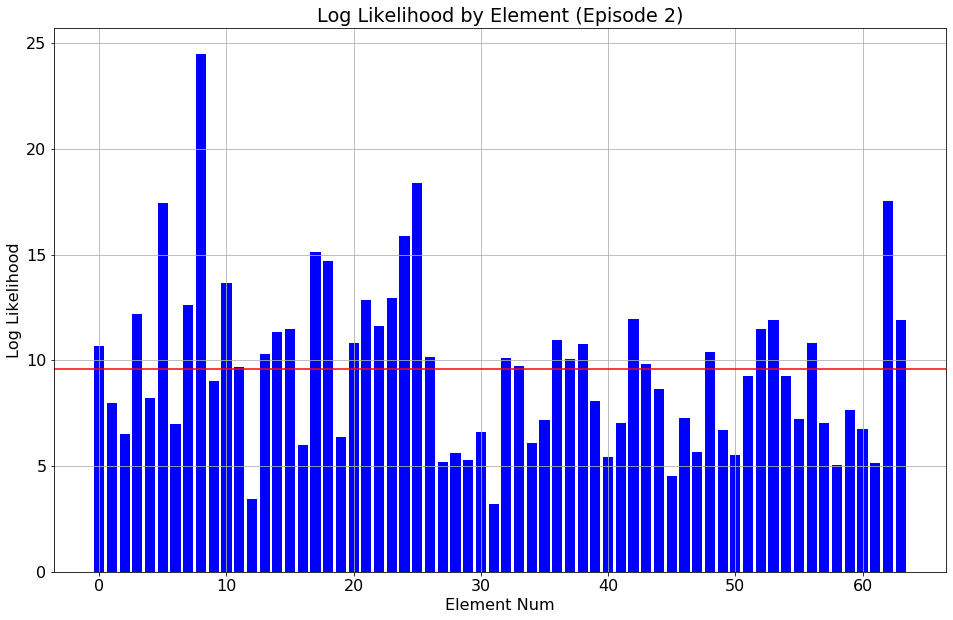

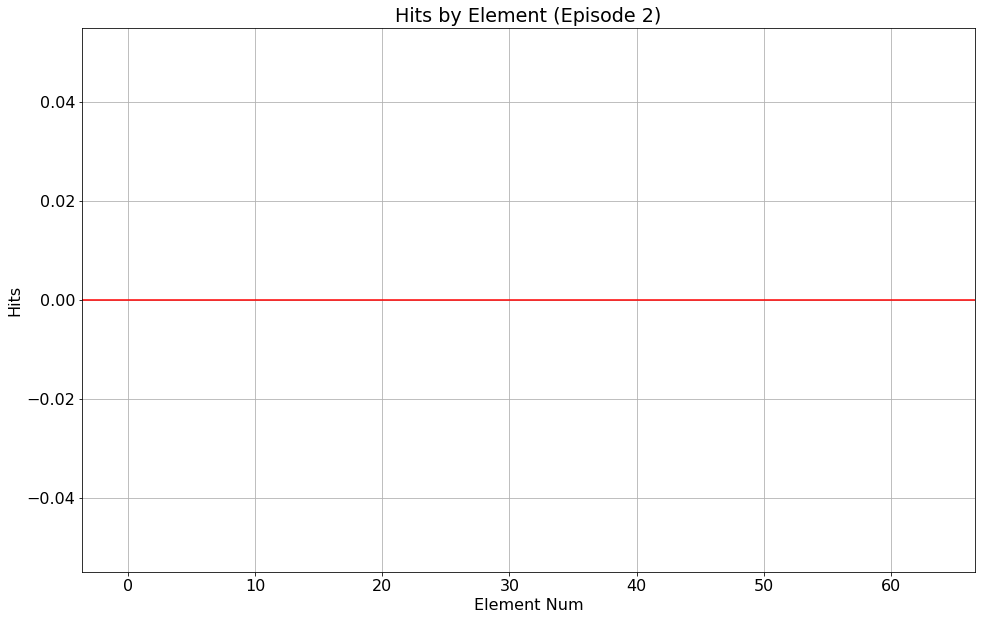


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.441e-04, training_time 25 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 5s 1ms/sample - loss: -754.1603
Epoch 10/12
4096/4096 [==============================] - 2s 555us/sample - loss: -928.7821
Epoch 11/12
4096/4096 [==============================] - 2s 552us/sample - loss: -1002.9214
Epoch 12/12
4096/4096 [==============================] - 2s 546us/sample - loss: -1052.2794
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    507.35 :   507.35 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     24.78 :    24.78 

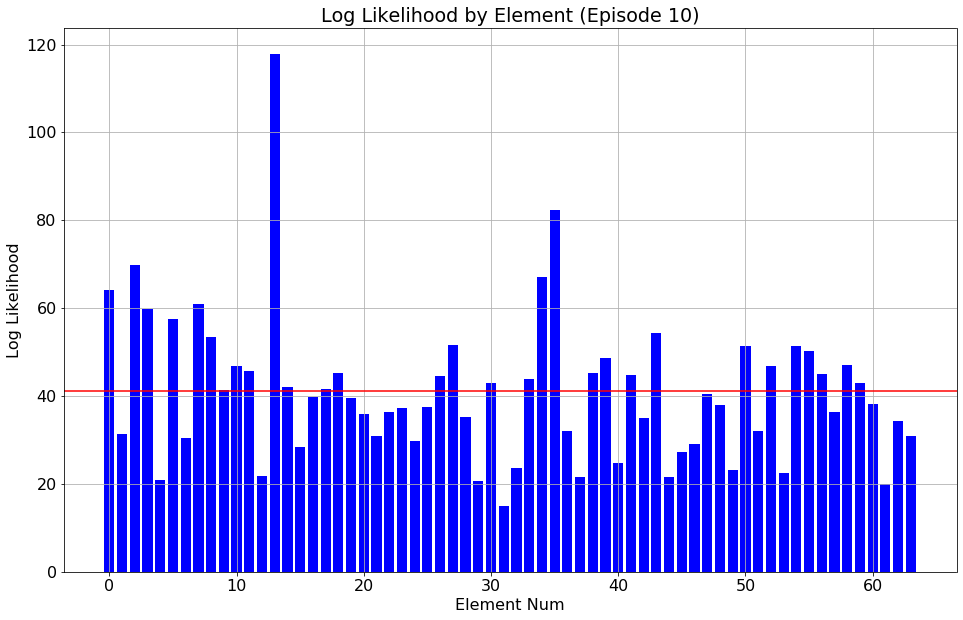

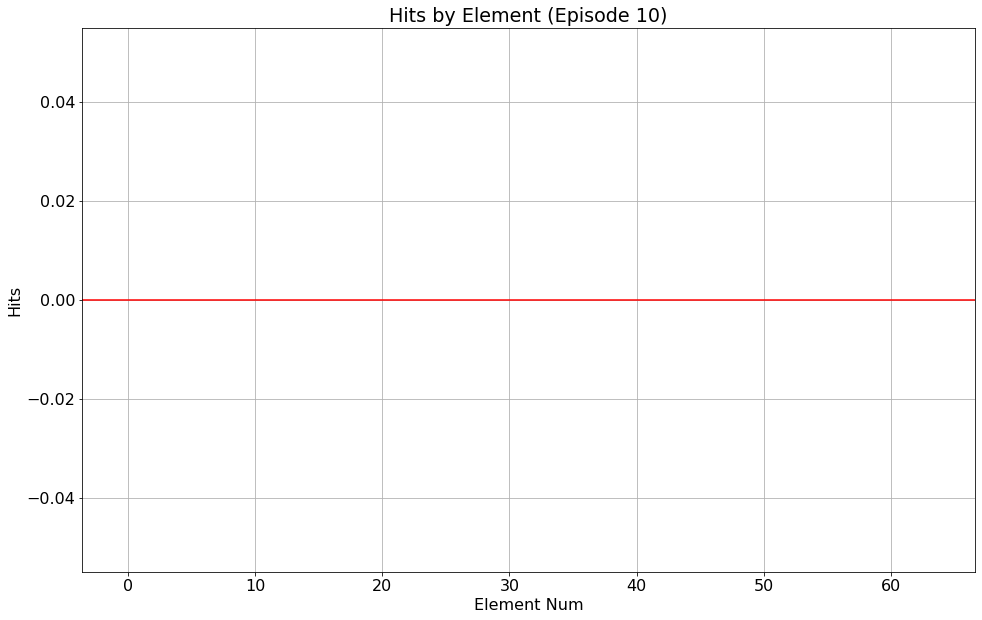


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 114 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 4s 915us/sample - loss: -32590909.1875
Epoch 42/44
4096/4096 [==============================] - 2s 458us/sample - loss: -39985515.3125
Epoch 43/44
4096/4096 [==============================] - 2s 453us/sample - loss: -48084239.2500
Epoch 44/44
4096/4096 [==============================] - 2s 450us/sample - loss: -56398513.1250
Adjusted element weight down on 10 candidate elements. Mean weight = 9.22e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    268.29 :   268.29 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      

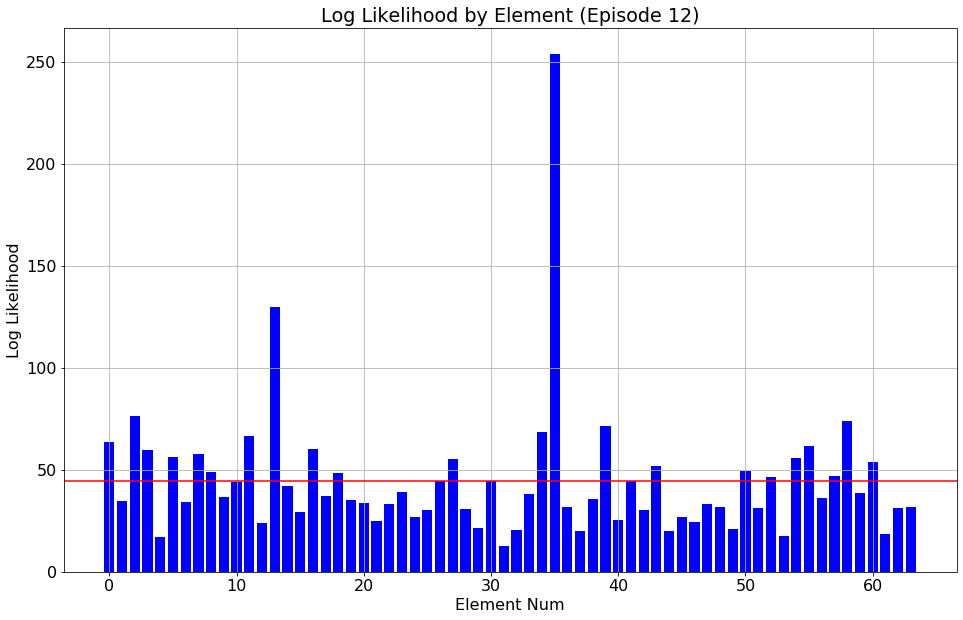

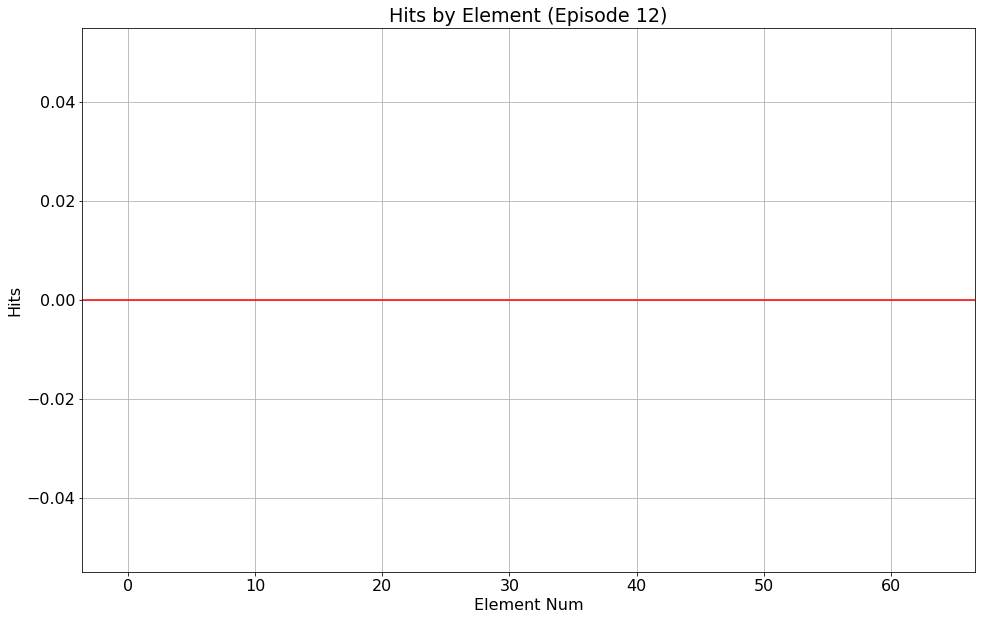


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=1.450e-04, training_time 134 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 5s 1ms/sample - loss: -1330.0510
Epoch 50/52
4096/4096 [==============================] - 2s 579us/sample - loss: -1366.3995
Epoch 51/52
4096/4096 [==============================] - 2s 567us/sample - loss: -1388.9649
Epoch 52/52
4096/4096 [==============================] - 2s 559us/sample - loss: -1408.7495
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    245.22 :   245.22 :      nan arc

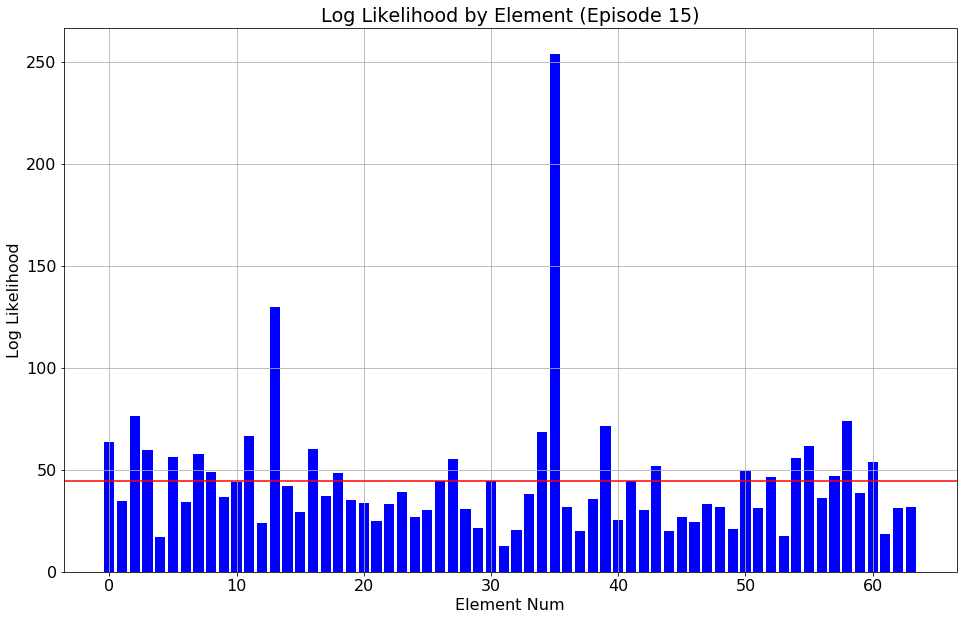

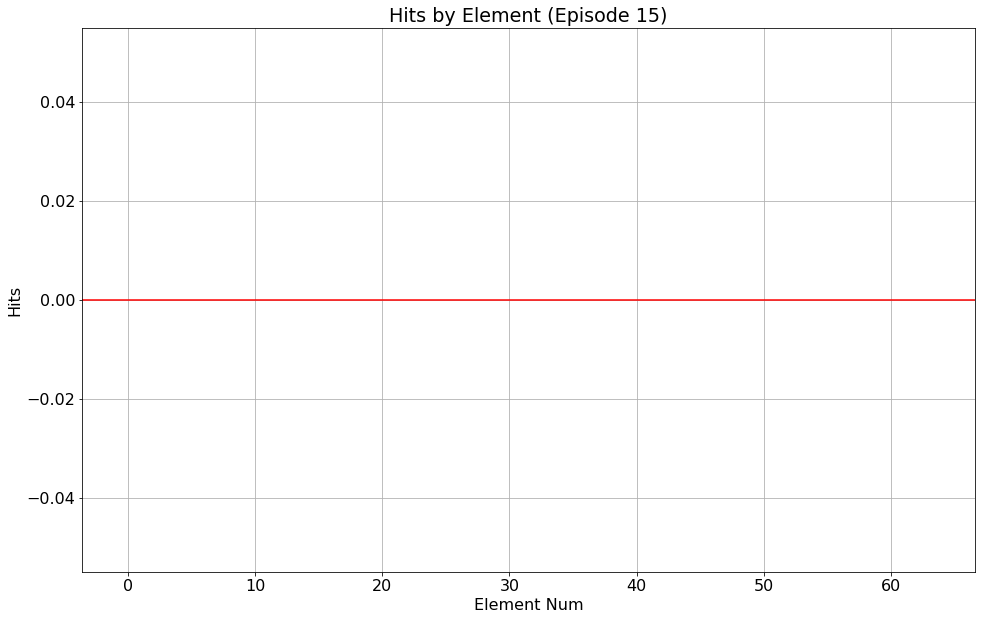


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 15: Epoch   60, Batch   3840
effective_learning_rate=2.441e-04, training_time 170 sec.
Train on 4096 samples
Epoch 61/64
4096/4096 [==============================] - 4s 1ms/sample - loss: -113530147.8750
Epoch 62/64
4096/4096 [==============================] - 2s 508us/sample - loss: -127163780.0000
Epoch 63/64
4096/4096 [==============================] - 2s 506us/sample - loss: -140948867.7500
Epoch 64/64
4096/4096 [==============================] - 2s 509us/sample - loss: -156733695.0000
Adjusted element weight down on 48 candidate elements. Mean weight = 6.25e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    245.40 :   245.40 :      nan arc seconds
Geom Mean Threshold :   3600.00 :  3600.00 :    

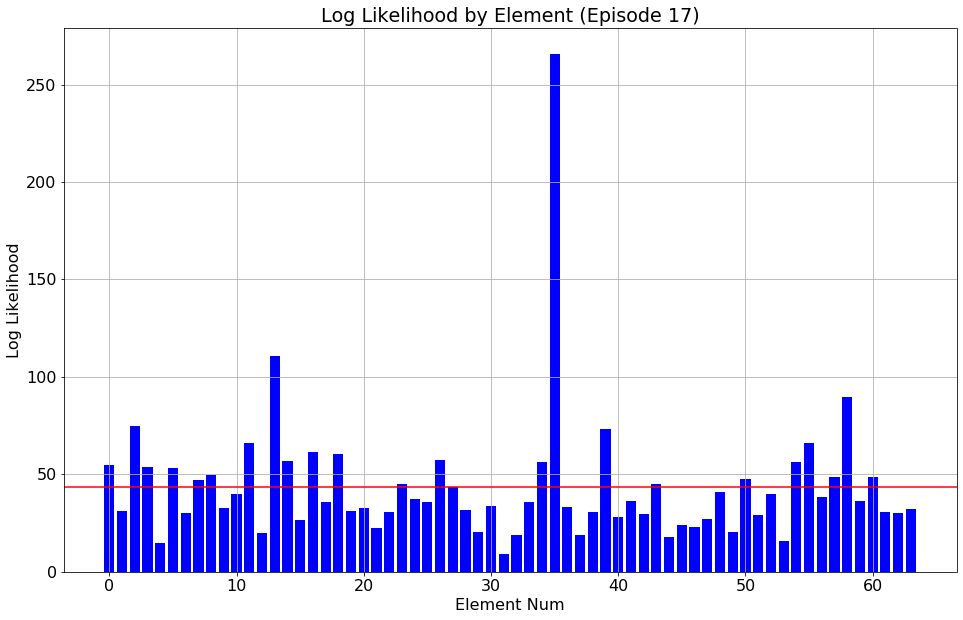

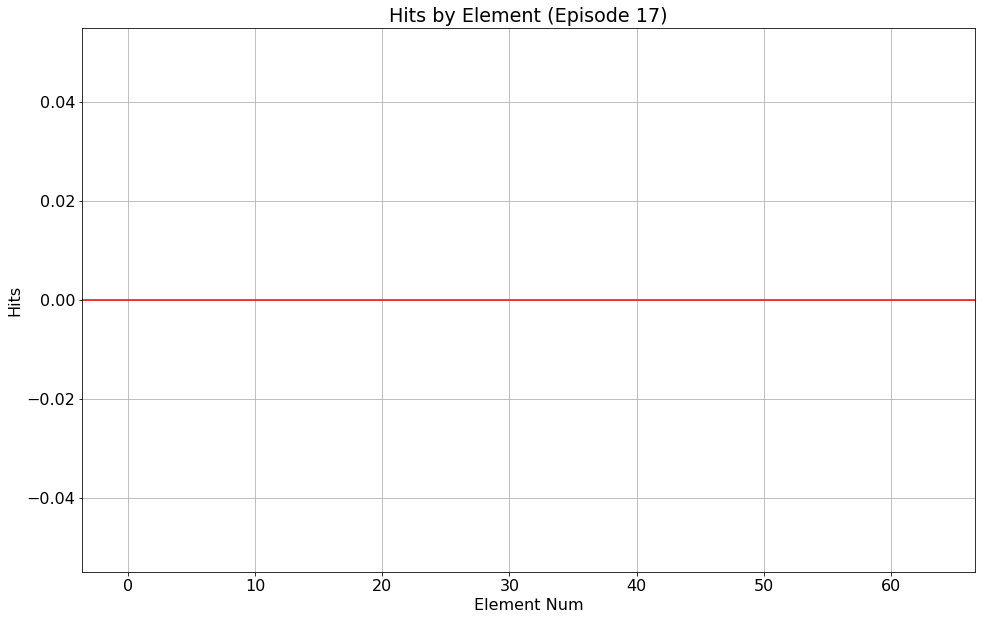


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 17: Epoch   68, Batch   4352
effective_learning_rate=1.106e-04, training_time 192 sec.
Train on 4096 samples
Epoch 69/72
4096/4096 [==============================] - 5s 1ms/sample - loss: -1008.9774
Epoch 70/72
4096/4096 [==============================] - 2s 590us/sample - loss: -1039.2210
Epoch 71/72
4096/4096 [==============================] - 3s 616us/sample - loss: -1057.7905
Epoch 72/72
4096/4096 [==============================] - 3s 614us/sample - loss: -1074.4666
Adjusted element weight down on 64 candidate elements. Mean weight = 6.25e-02
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    240.99 :   240.99 :      nan arc

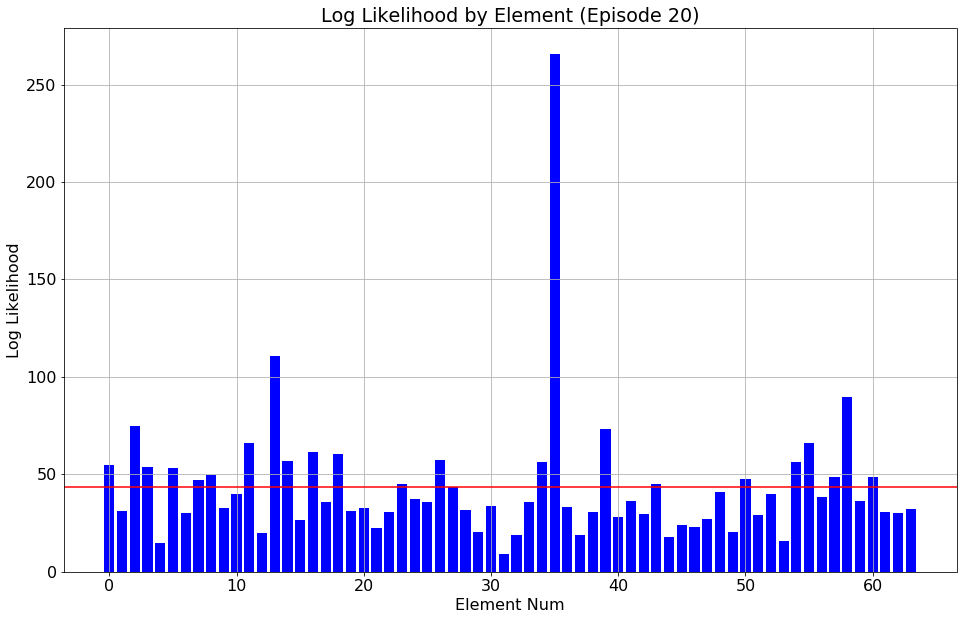

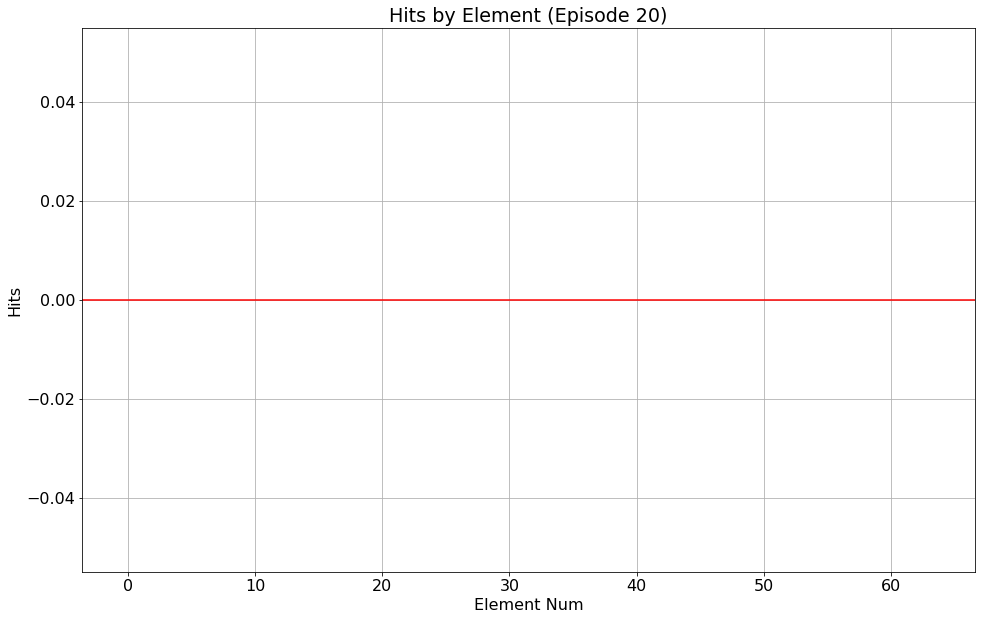


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 20: Epoch   80, Batch   5120
effective_learning_rate=2.441e-04, training_time 228 sec.
Train on 4096 samples
Epoch 81/84
4096/4096 [==============================] - 4s 884us/sample - loss: -180935631.7500
Epoch 82/84
4096/4096 [==============================] - 2s 484us/sample - loss: -198404007.5000
Epoch 83/84
4096/4096 [==============================] - 2s 492us/sample - loss: -215455380.7500
Epoch 84/84
4096/4096 [==============================] - 2s 499us/sample - loss: -233913815.0000
Adjusted element weight down on 47 candidate elements. Mean weight = 6.33e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    246.42 :   246.42 :      nan arc seconds
Geom Mean Threshold :   2400.00 :  2400.00 :  

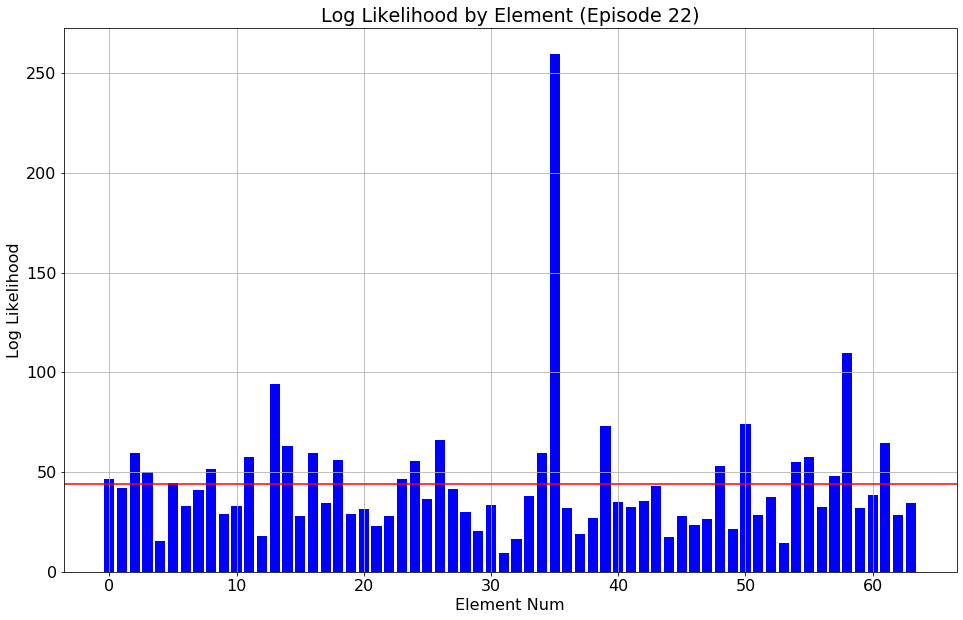

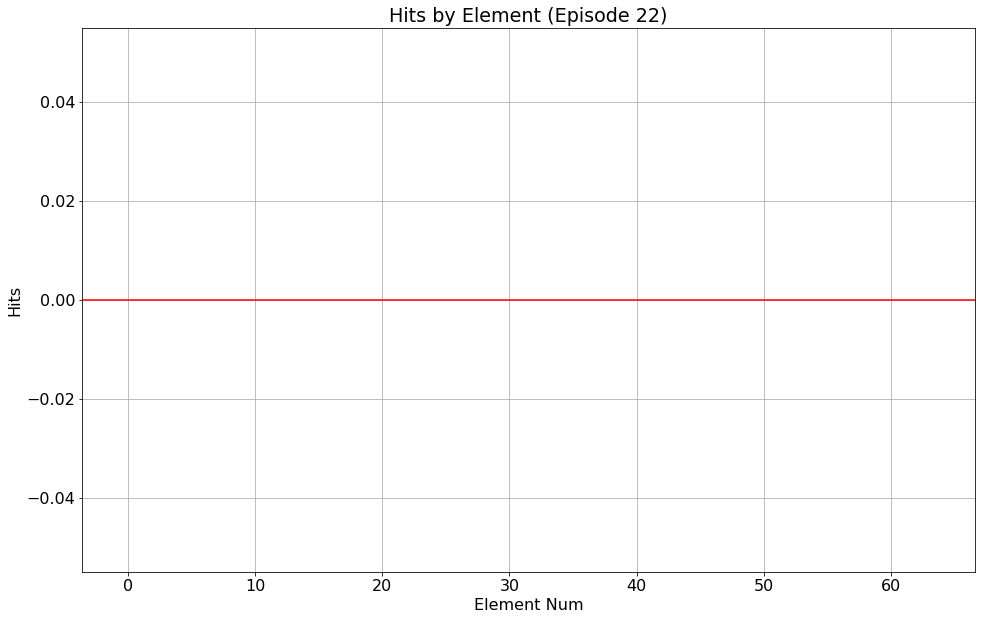


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   5632
effective_learning_rate=1.059e-04, training_time 249 sec.
Train on 4096 samples
Epoch 89/92
4096/4096 [==============================] - 5s 1ms/sample - loss: -966.9483
Epoch 90/92
4096/4096 [==============================] - 3s 618us/sample - loss: -989.4483
Epoch 91/92
4096/4096 [==============================] - 3s 611us/sample - loss: -1007.1504
Epoch 92/92
4096/4096 [==============================] - 2s 595us/sample - loss: -1024.7235
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    255.29 :   255.29 :      nan arc seconds
Geom Mean Threshold :   2400.00 :  2400.00 :      nan arc seconds
Mean Log Likelihood :     49.06 :    49.

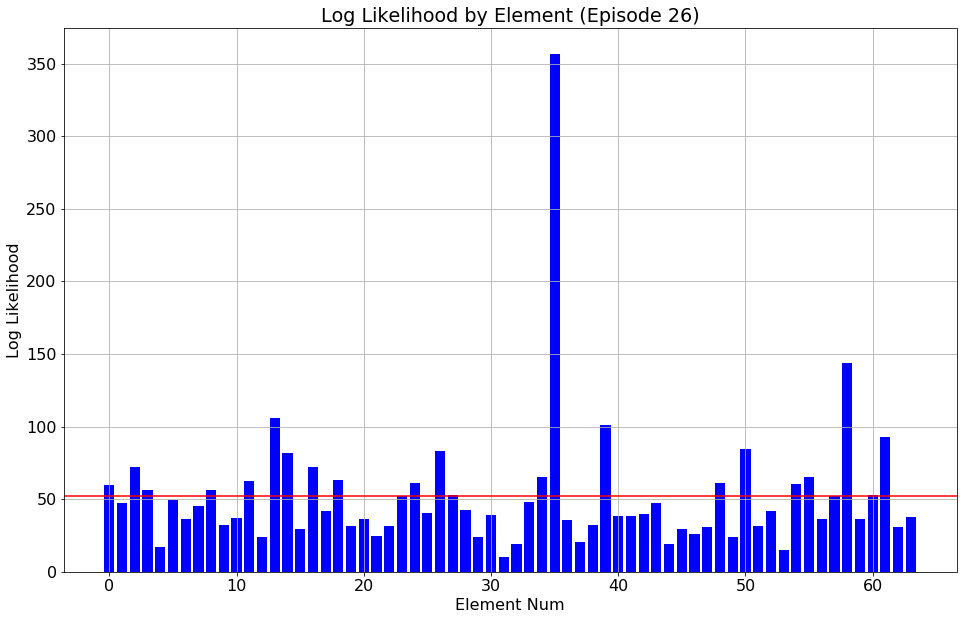

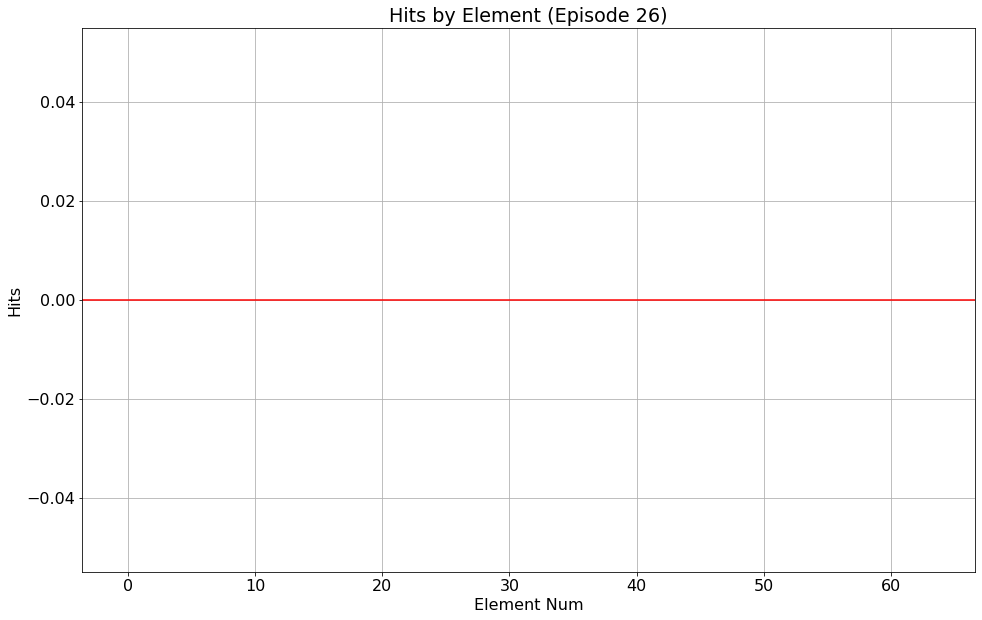


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 26: Epoch  104, Batch   6656
effective_learning_rate=1.221e-04, training_time 299 sec.
Train on 4096 samples
Epoch 105/108
4096/4096 [==============================] - 4s 906us/sample - loss: -32756882571264.0000
Epoch 106/108
4096/4096 [==============================] - 2s 522us/sample - loss: -39933763911680.0000
Epoch 107/108
4096/4096 [==============================] - 2s 514us/sample - loss: -49851367686144.0000
Epoch 108/108
4096/4096 [==============================] - 2s 532us/sample - loss: -63801603915776.0000
Adjusted element weight down on 55 candidate elements. Mean weight = 5.70e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    249.67 :   256.

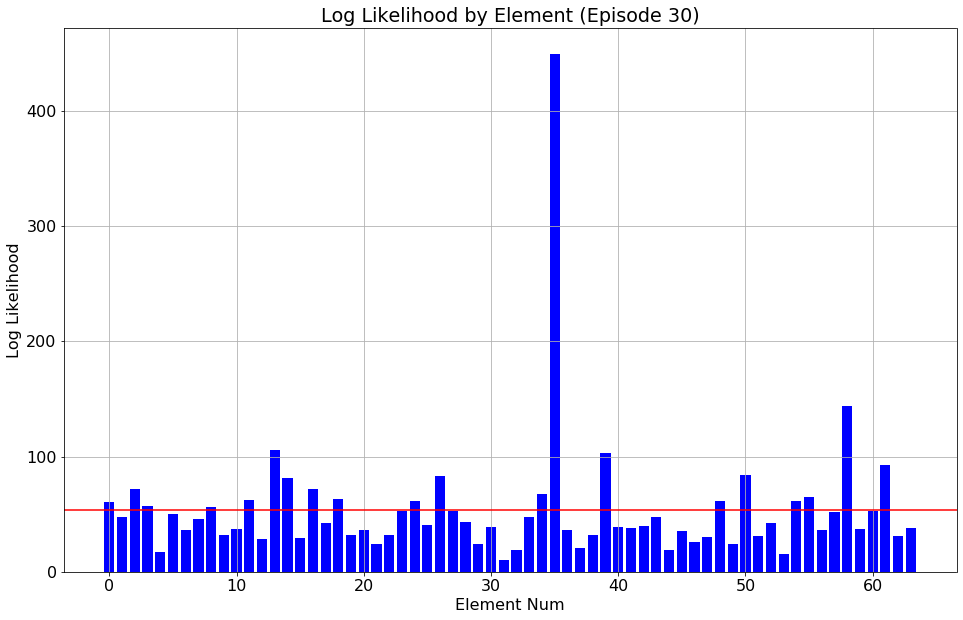

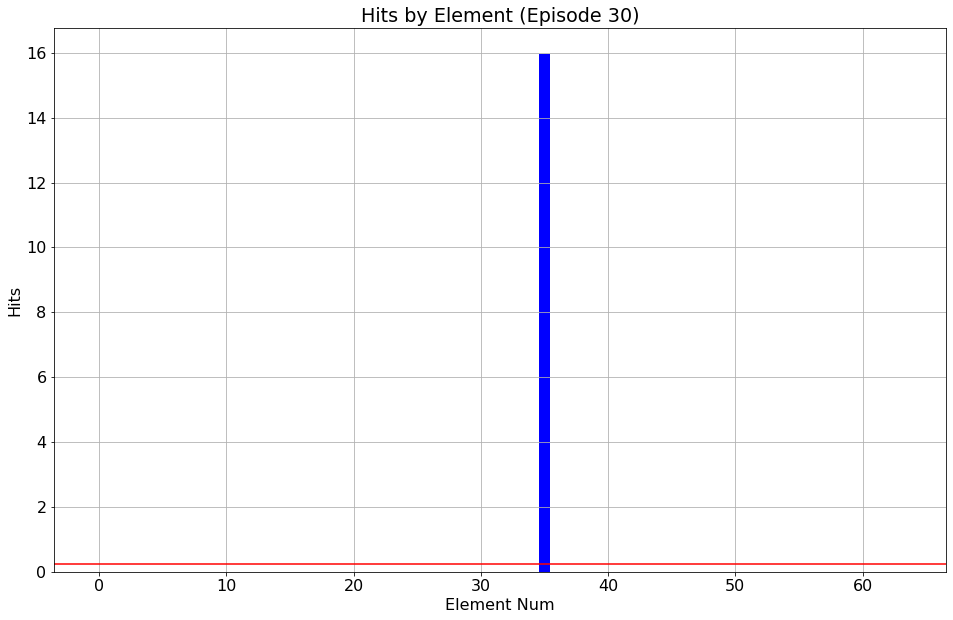


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 30: Epoch  120, Batch   7680
effective_learning_rate=3.815e-06, training_time 339 sec.
Train on 4096 samples
Epoch 121/124
4096/4096 [==============================] - 5s 1ms/sample - loss: -181733365.7500
Epoch 122/124
4096/4096 [==============================] - 3s 653us/sample - loss: -183186808.7500
Epoch 123/124
4096/4096 [==============================] - 3s 642us/sample - loss: -184201570.0000
Epoch 124/124
4096/4096 [==============================] - 3s 676us/sample - loss: -185072902.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    236.

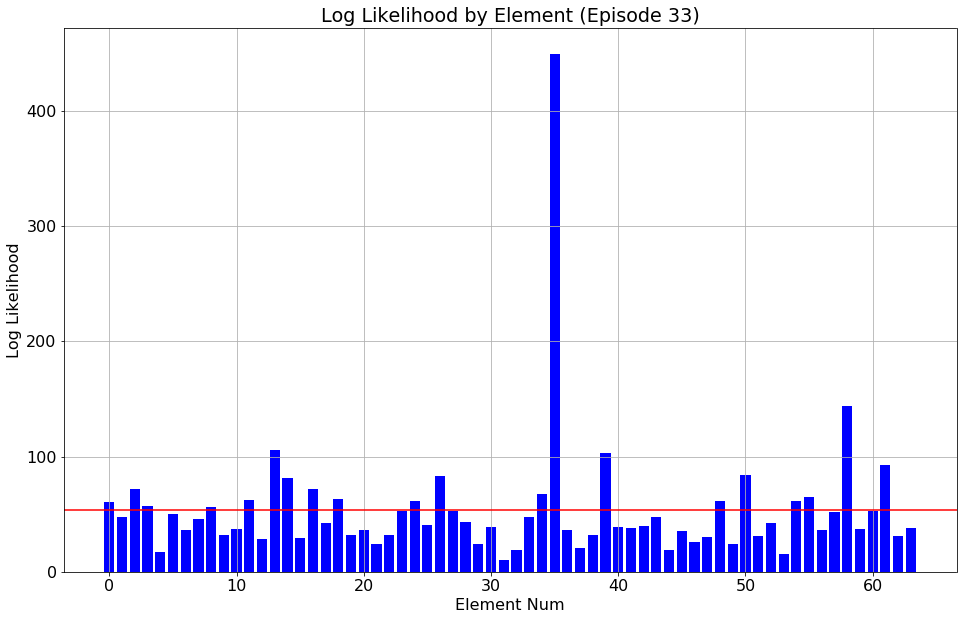

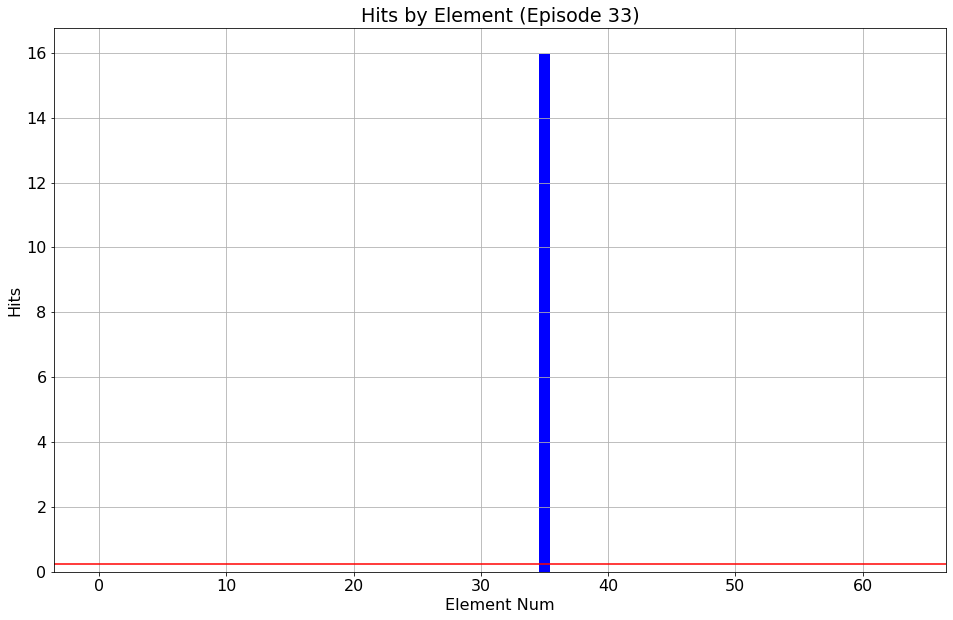


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 33: Epoch  132, Batch   8448
effective_learning_rate=3.815e-06, training_time 379 sec.
Train on 4096 samples
Epoch 133/136
4096/4096 [==============================] - 5s 1ms/sample - loss: -170688783581184.0000
Epoch 134/136
4096/4096 [==============================] - 3s 673us/sample - loss: -172596272562176.0000
Epoch 135/136
4096/4096 [==============================] - 3s 663us/sample - loss: -174081444151296.0000
Epoch 136/136
4096/4096 [==============================] - 3s 672us/sample - loss: -175427932651520.0000
Adjusted element weight down on 15 candidate elements. Mean weight = 8.83e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    235.57 :   243.2

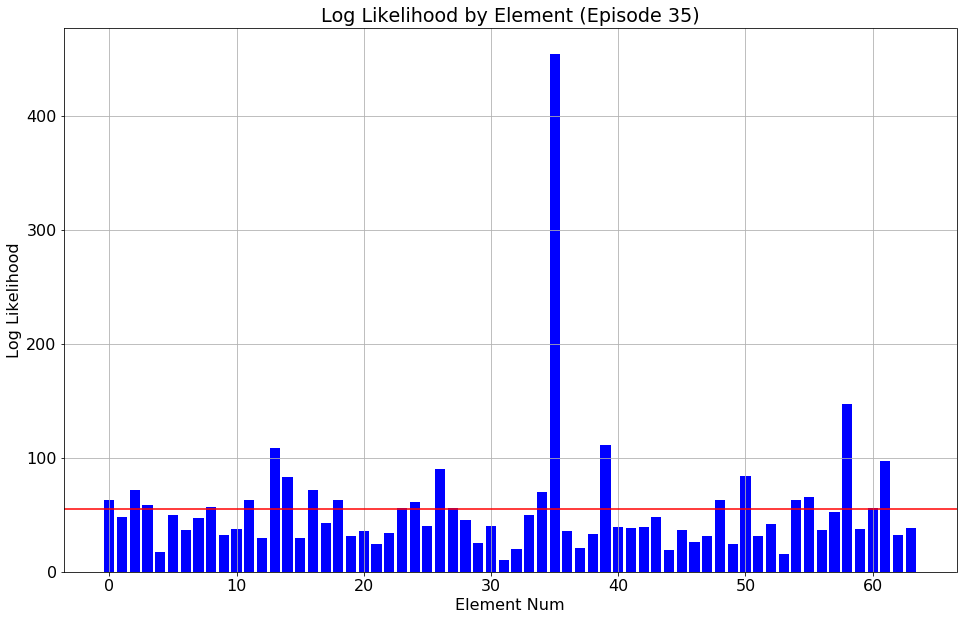

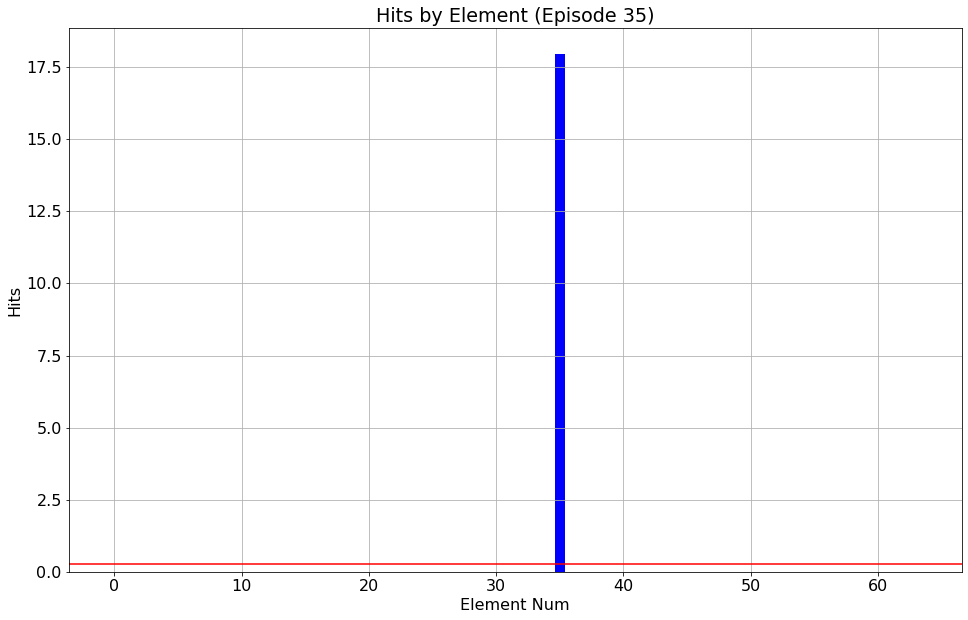

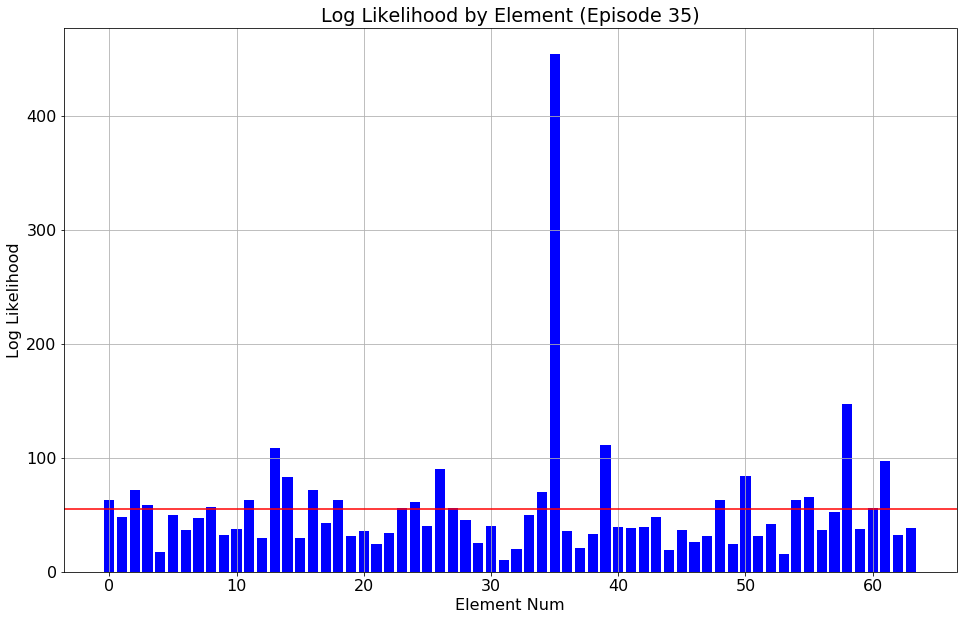

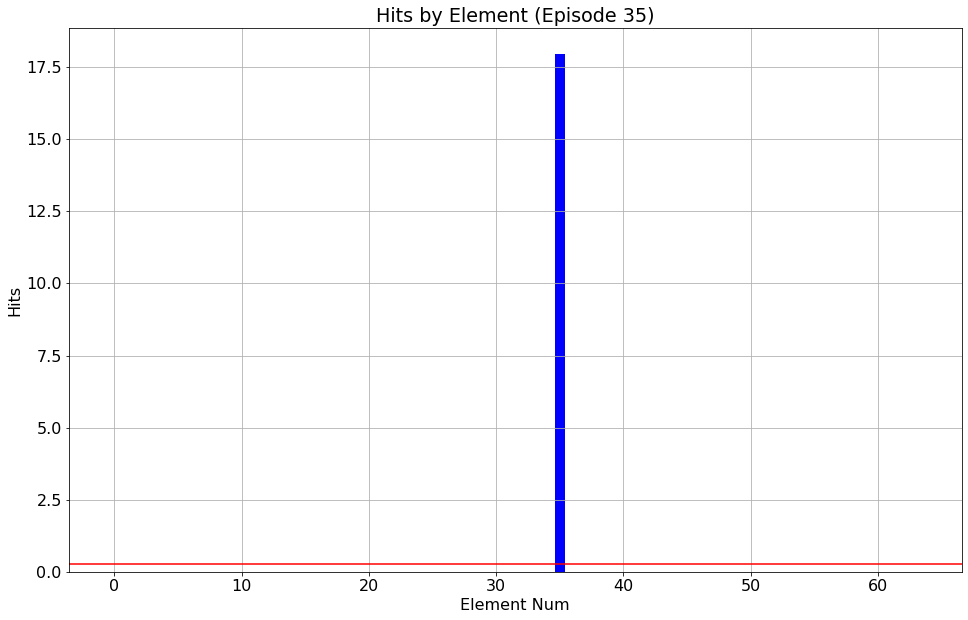

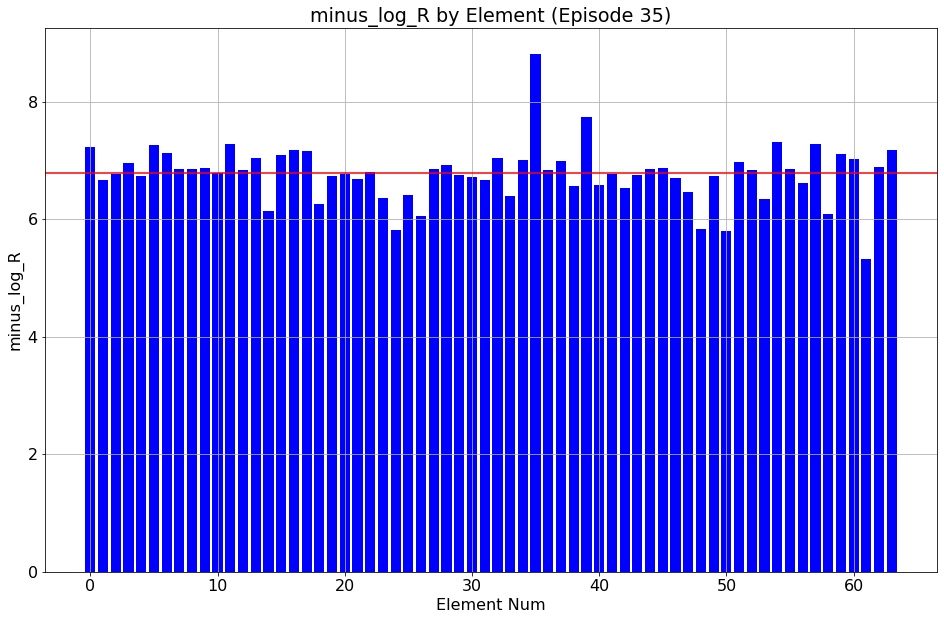

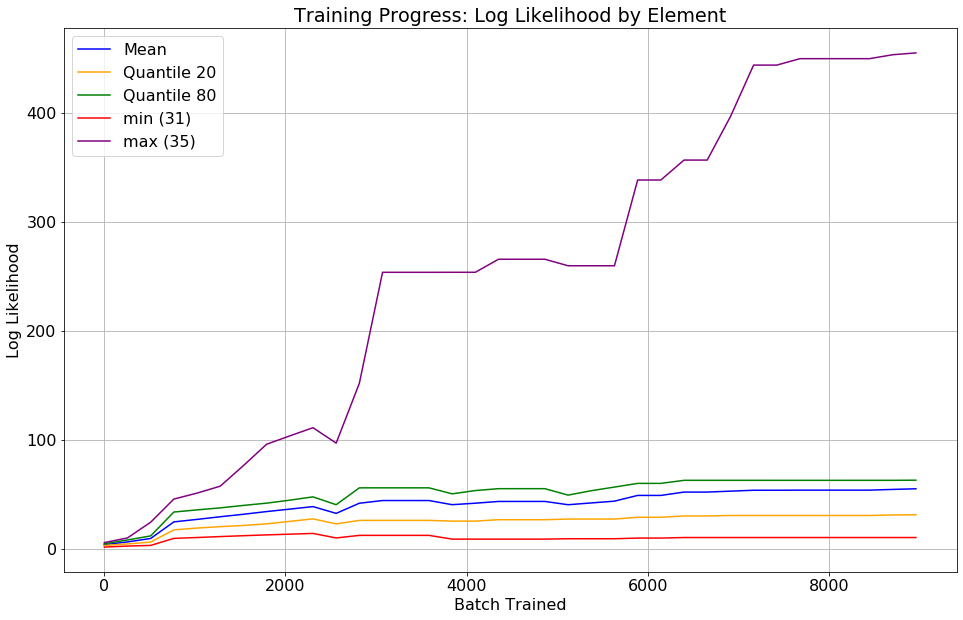

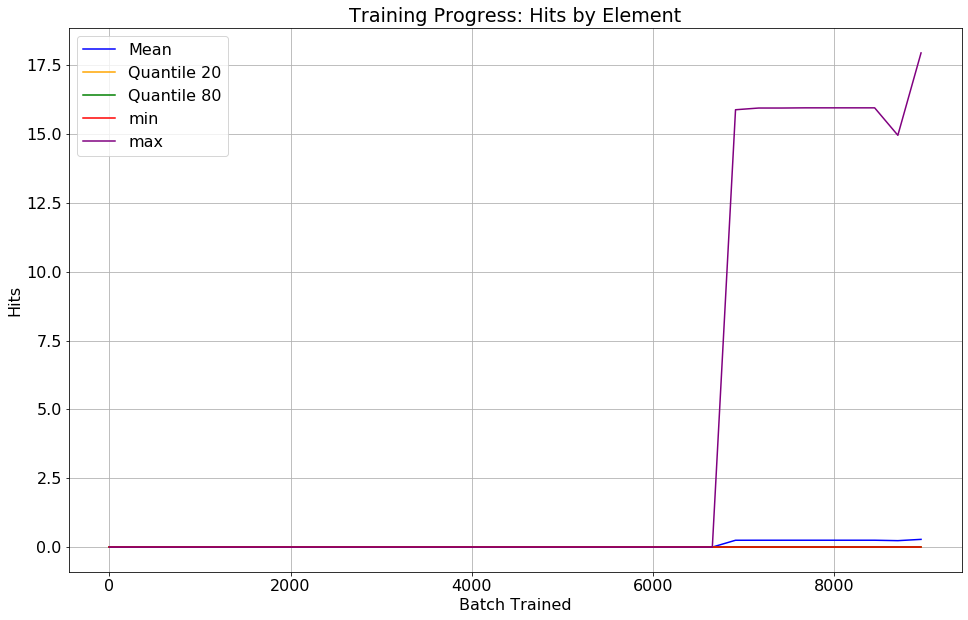

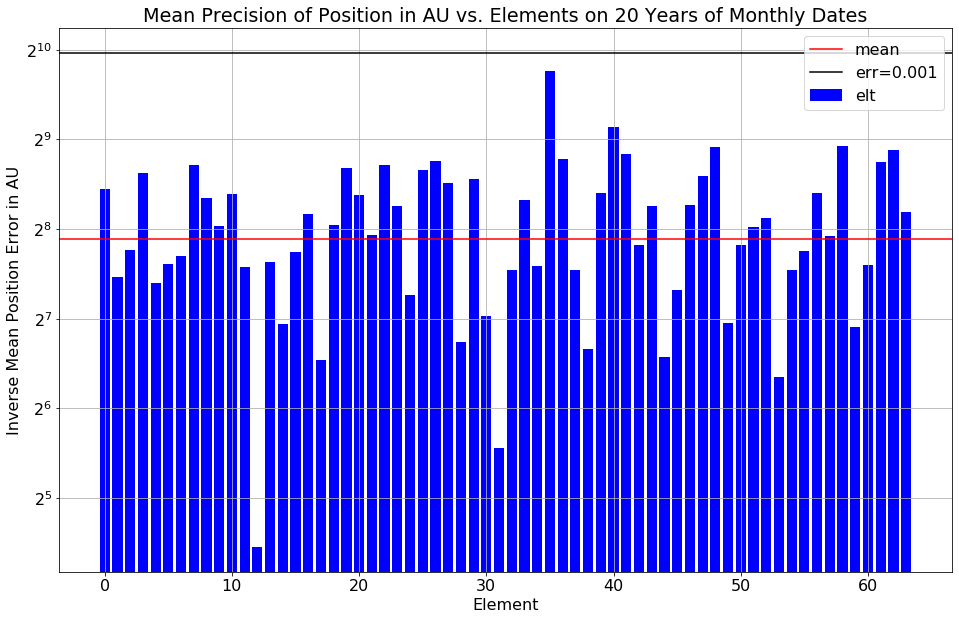

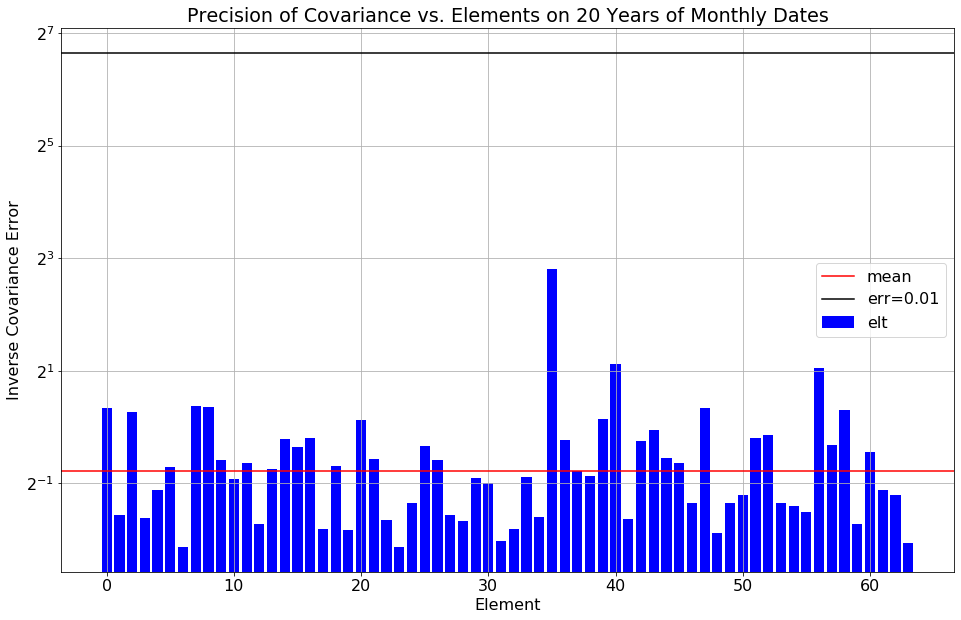

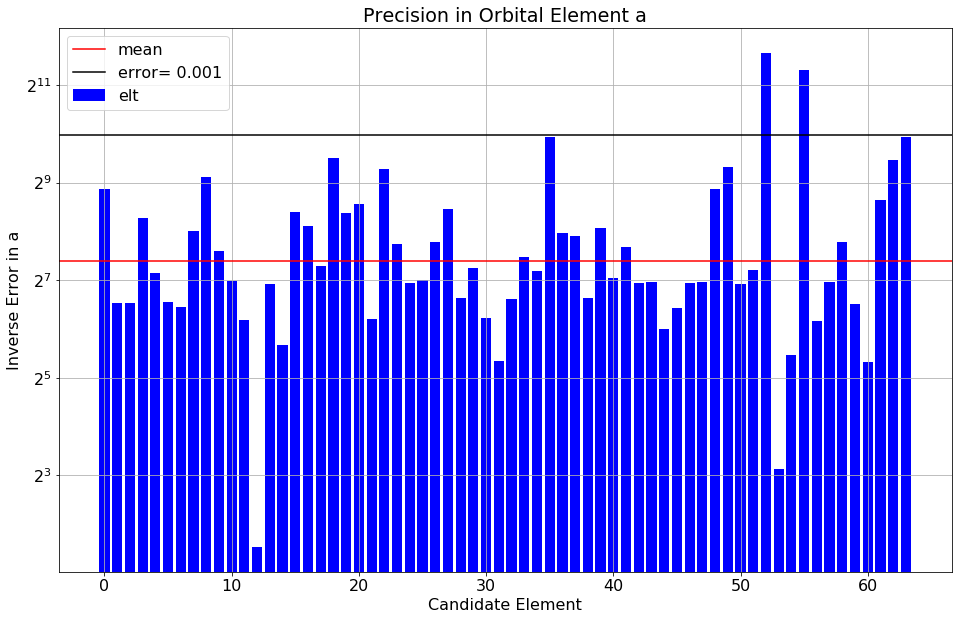

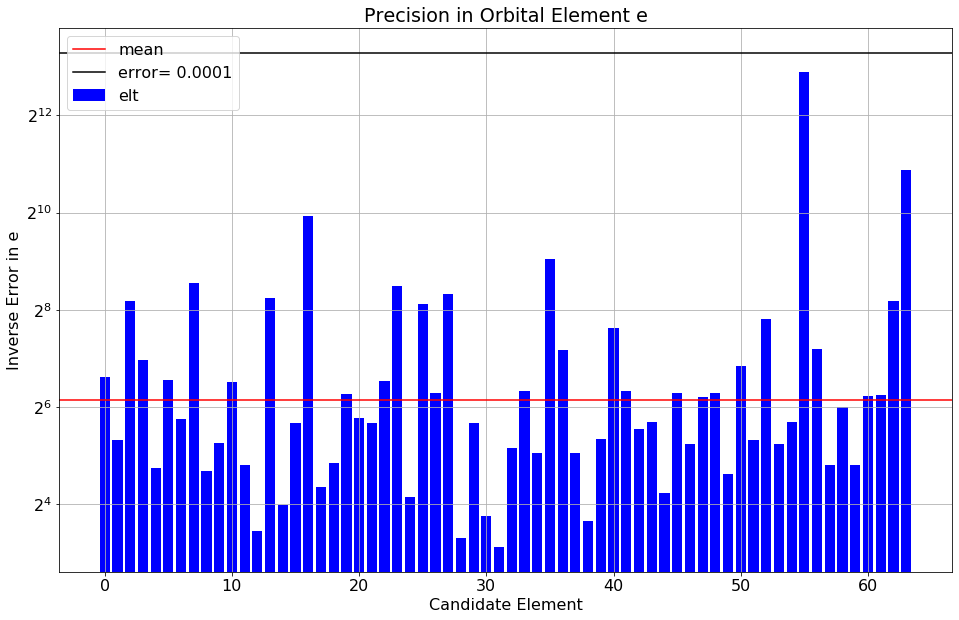

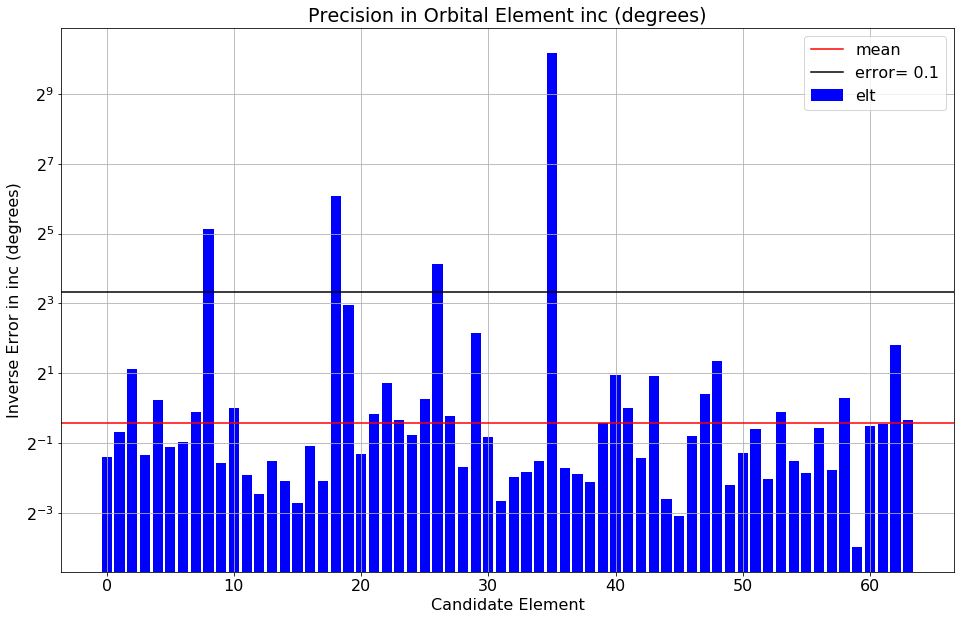

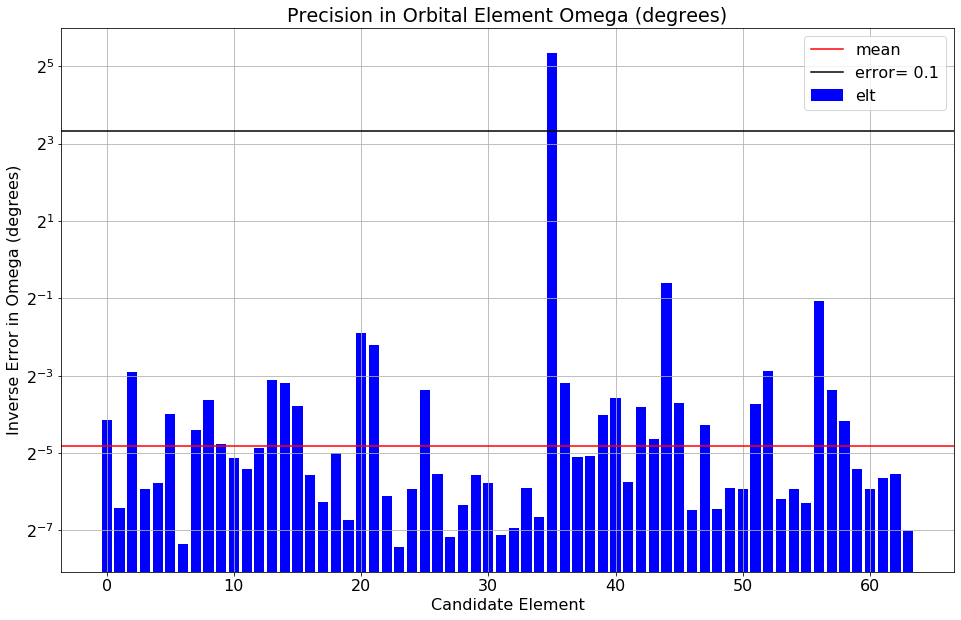

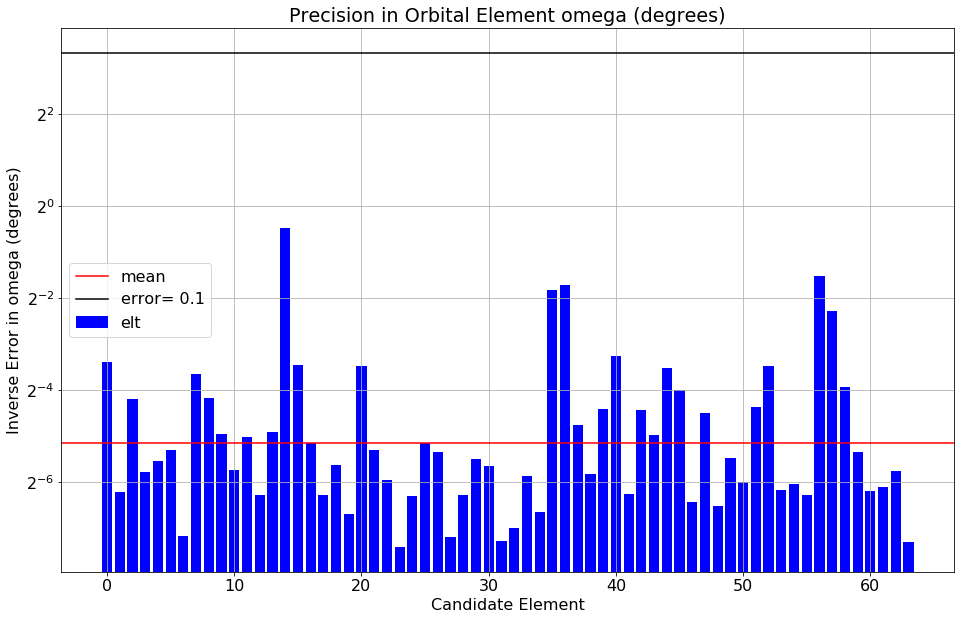

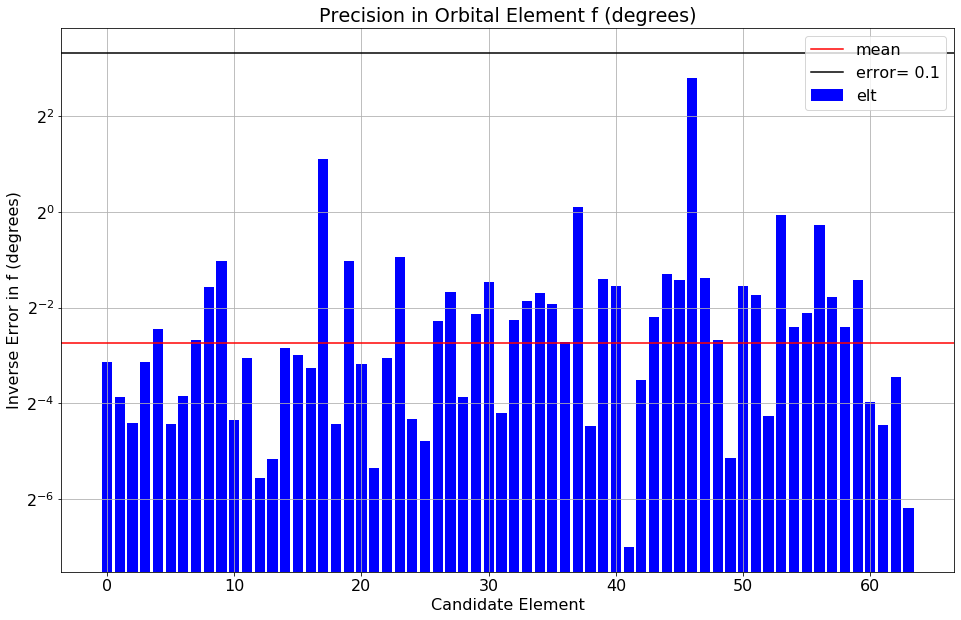

In [29]:
model.sieve(nearest_ast=True)

In [30]:
model.report()


Good elements (hits >= 10):   1.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   454.81  :  18.00 :    30.67 :  1307.29
Mean Bad :    48.80  :   0.00 :   267.09 :  2383.38
Mean     :    55.14  :   0.28 :   263.40 :  2366.56
Median   :    41.31  :   0.00 :   224.91 :  2400.00
GeoMean  :    44.88  :   0.05 :   234.31 :  2360.49
Min      :    10.45  :   0.00 :    30.67 :  1307.29
Max      :   454.81  :  18.00 :  1005.68 :  2400.00
Trained for 8960 batches over 140 epochs and 35 episodes (elapsed time 408 seconds).


## Review Results Graphically

In [31]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [32]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [33]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

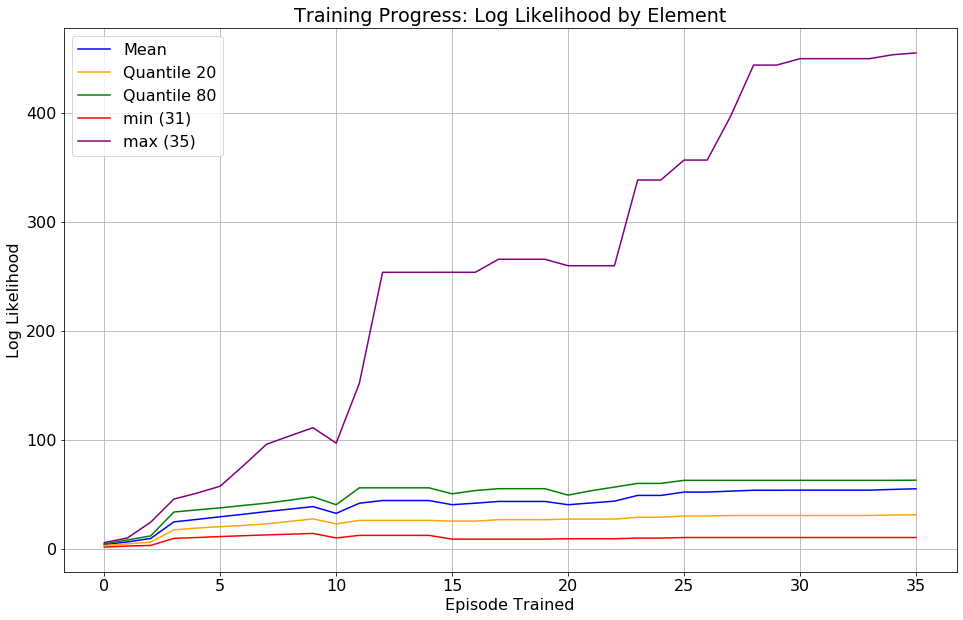

In [34]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like', 'episode')

In [35]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [36]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [37]:
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,2.978956,0.101788,0.068398,0.658168,0.933732,-1.306563,58600.0,62.425659,0.000723,...,0.666667,2399.999756,62.673969,0.0,1865.0,15.974840,3.544147,1012289,0.002863,0.794257
1,1,2.831838,0.150273,0.066913,1.347967,6.136132,-0.490949,58600.0,82.120476,0.001260,...,0.666667,2399.999756,48.208534,0.0,1418.0,16.310892,3.545825,272977,0.005661,2.937889
2,2,2.960929,0.088910,0.047548,3.958978,0.682959,1.887591,58600.0,112.884590,0.001143,...,0.666667,2399.999756,72.265526,0.0,1803.0,15.763766,3.524533,127327,0.004575,0.830032
3,3,2.658258,0.103467,0.013197,1.576113,5.263556,0.134165,58600.0,50.075531,0.000956,...,0.666667,2399.999756,58.470455,0.0,1317.0,15.830400,3.534925,1088186,0.002539,3.057565
4,4,3.073641,0.253890,0.089741,0.087529,4.323670,2.604012,58600.0,36.728962,0.001184,...,0.666667,2399.999756,17.439747,0.0,1148.0,15.766717,3.550001,1030466,0.005905,2.169327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.882780,0.090757,0.038172,0.677878,3.239929,3.124521,58600.0,50.654285,0.000821,...,0.666667,2399.999756,37.818359,0.0,1253.0,17.298191,3.544742,1179500,0.008335,3.303501
60,60,3.183361,0.083248,0.049170,5.196827,0.898378,0.848946,58600.0,67.847221,0.000882,...,0.666667,2399.999756,55.696598,0.0,1453.0,15.750342,3.540370,462127,0.005147,1.351407
61,61,2.327797,0.061718,0.065770,4.756670,1.889296,-1.124582,58600.0,210.827118,0.004876,...,0.666667,2399.999756,97.406281,0.0,868.0,17.077398,3.537102,230169,0.002329,2.175525
62,62,2.321995,0.181566,0.048024,3.274917,2.244553,-0.596802,58600.0,39.368713,0.001022,...,0.666667,2399.999756,32.496307,0.0,581.0,17.242323,3.553701,187111,0.002126,2.308654


In [38]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 1 asteroids.
Mean on converged asteroids:
Number of hits         : 17.96
Resolution in arc sec  : 30.67
GeoMean Distance in AU : 1.15e-03
Covariance norm        : 1.43e-01


In [39]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
35,35,454.81424,17.95529,30.666328,1307.292847,49846,0.001147,0.143482


In [40]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [41]:
# model.elts_near_ast

In [42]:
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,2.978956,0.101788,0.068398,0.658168,0.933732,-1.306563,58600.0,62.425659,0.000723,...,0.666667,2399.999756,62.673969,0.0,1865.0,15.974840,3.544147,1012289,0.002863,0.794257
1,1,2.831838,0.150273,0.066913,1.347967,6.136132,-0.490949,58600.0,82.120476,0.001260,...,0.666667,2399.999756,48.208534,0.0,1418.0,16.310892,3.545825,272977,0.005661,2.937889
2,2,2.960929,0.088910,0.047548,3.958978,0.682959,1.887591,58600.0,112.884590,0.001143,...,0.666667,2399.999756,72.265526,0.0,1803.0,15.763766,3.524533,127327,0.004575,0.830032
3,3,2.658258,0.103467,0.013197,1.576113,5.263556,0.134165,58600.0,50.075531,0.000956,...,0.666667,2399.999756,58.470455,0.0,1317.0,15.830400,3.534925,1088186,0.002539,3.057565
4,4,3.073641,0.253890,0.089741,0.087529,4.323670,2.604012,58600.0,36.728962,0.001184,...,0.666667,2399.999756,17.439747,0.0,1148.0,15.766717,3.550001,1030466,0.005905,2.169327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.882780,0.090757,0.038172,0.677878,3.239929,3.124521,58600.0,50.654285,0.000821,...,0.666667,2399.999756,37.818359,0.0,1253.0,17.298191,3.544742,1179500,0.008335,3.303501
60,60,3.183361,0.083248,0.049170,5.196827,0.898378,0.848946,58600.0,67.847221,0.000882,...,0.666667,2399.999756,55.696598,0.0,1453.0,15.750342,3.540370,462127,0.005147,1.351407
61,61,2.327797,0.061718,0.065770,4.756670,1.889296,-1.124582,58600.0,210.827118,0.004876,...,0.666667,2399.999756,97.406281,0.0,868.0,17.077398,3.537102,230169,0.002329,2.175525
62,62,2.321995,0.181566,0.048024,3.274917,2.244553,-0.596802,58600.0,39.368713,0.001022,...,0.666667,2399.999756,32.496307,0.0,581.0,17.242323,3.553701,187111,0.002126,2.308654


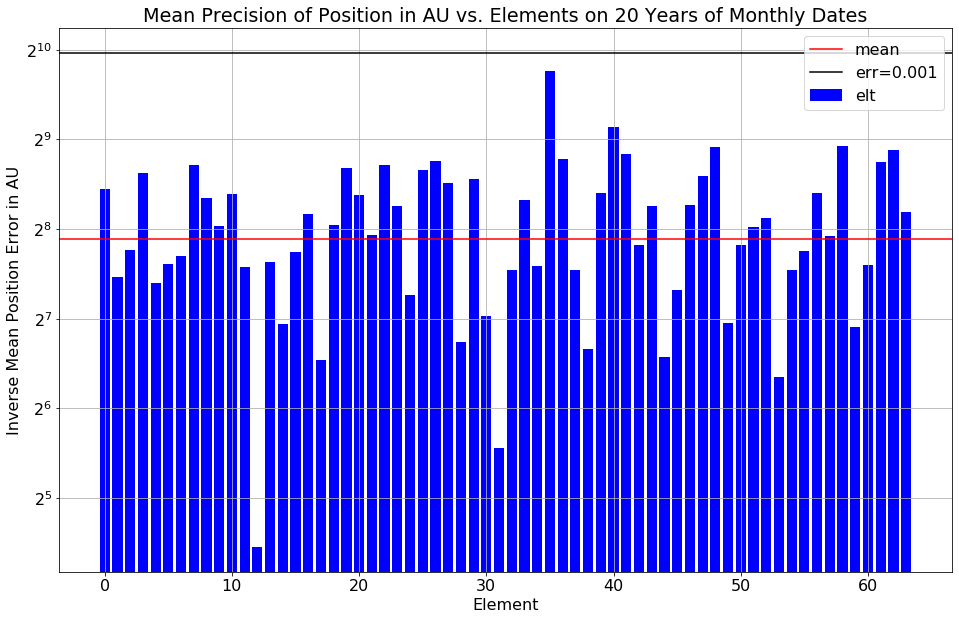

In [43]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

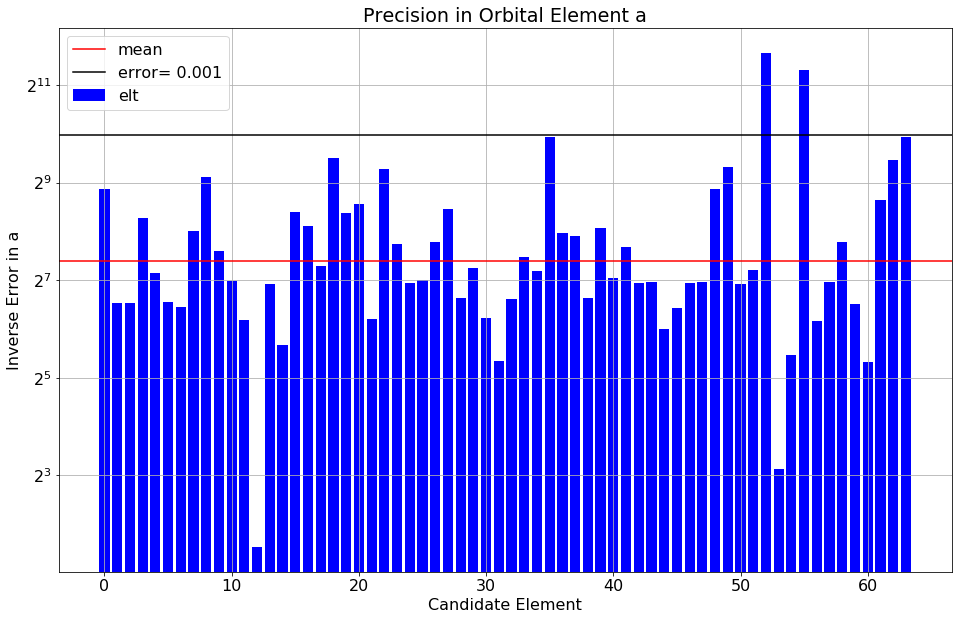

In [44]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

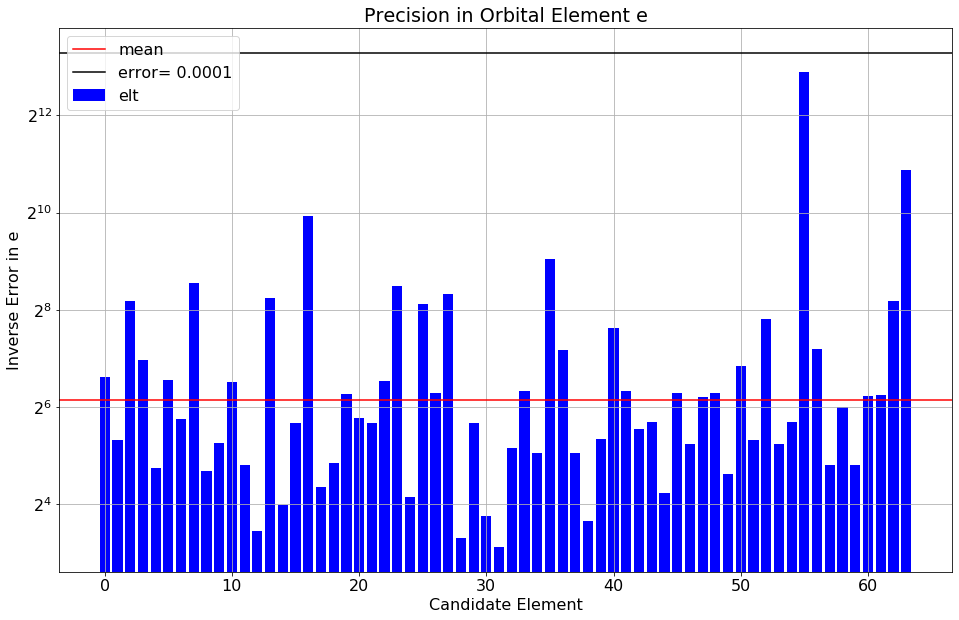

In [45]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)